In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# For Figures in Results Section about d18O signal at WDC and what drives it
## End results are figures of the T2M response to SAM, PSA1, PSA2 (by quartile differences) with contours of the T2M field with WDC d18O record
## Will need to focus on 1980-2000 (MERRA, the WDC dates are 1982-2002 bc they are offset by 2 years)

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm
from cartopy.util import add_cyclic_point
import netCDF4
from scipy import stats


%matplotlib inline

In [3]:
############# to be set #############

                         
##Load ERA indice .pkl's
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_For_REVIEW_Submission_24March2021'



In [4]:

##Specific to MERRA2, ie, not the same chunk and slices as iCESM
XCHUNK = 240 #Full size chunk seems to make things run quickest
YCHUNK = 121 #Full Y size chunk makes things run quickest
#ZCHUNK = 30 #Full Z size chunk 
TCHUNK = 456  #Full T size

##Find .nc file path
NETCDF_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'



In [5]:
#For MERRA, decode_cf needs to be set to True for proper concatenation on T axis
MERRA_DATA = xr.open_dataset(NETCDF_PATH+'/MERRA_DATA.nc')
print(MERRA_DATA)

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240, time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    skint    (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    u10      (time, lat, lon) float32 ...
    v10      (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
    ci       (time, lat, lon) float32 ...


In [6]:
#getting variables in right units 
slp_tmon_merra = MERRA_DATA.msl/100 #hPa
v10_tmon_merra = MERRA_DATA.v10 #in m/s at 10m
u10_tmon_merra = MERRA_DATA.u10 #in m/s at 10m
t2m_tmon_merra = MERRA_DATA.t2m-273.15 #in C
tp_tmon_merra  = MERRA_DATA.tp*60*60*24*1000/1000  #in mm/day
ci_tmon_merra  = MERRA_DATA.ci #in [0-1] fraction of sea ice
sst_tmon_merra = MERRA_DATA.sst #SST in C -- taken care of when making the xarray/.nc file


In [7]:
sst_tmon_merra

<xarray.DataArray 'sst' (time: 456, lat: 121, lon: 240)>
[13242240 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

In [8]:
#Open pandas dfs of all indices and ASL information
# pdo_index_merra = pd.read_pickle(PICKLE_PATH+'/merra_pdo_tmon.pkl')
# # pdo_index_merra.head(n=5)
# pdo_seas_mean_index_merra = pd.read_pickle(PICKLE_PATH+'/merra_pdo_seas.pkl')
# # pdo_seas_mean_index_merra.head(n=5)
# pdo_ann_mean_index_merra = pd.read_pickle(PICKLE_PATH+'/merra_pdo_ann_mean.pkl')
# # pdo_ann_mean_index_merra.head(n=5)

enso_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_tmon.pkl')
# enso_indices_merra.head(n=5)
enso_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_seas.pkl')
# enso_seas_mean_indices_merra.head(n=5)
enso_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_ann_mean.pkl')
# enso_ann_mean_indices_merra.head(n=5)
enso_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_12roll_mean.pkl')
# enso_12roll_mean_indices_merra.head(n=10)
enso_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_6roll_mean.pkl')
# enso_6roll_mean_indices_merra.head(n=5)
enso_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_3roll_mean.pkl')
# enso_3roll_mean_indices_merra.head(n=5)
enso_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_band_filt.pkl')
# enso_band_filt_indices_merra.head(n=5)

SAM_PSAs_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_tmon.pkl')
# SAM_PSAs_indices_merra.head(n=5)
SAM_PSAs_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_seas.pkl')
# SAM_PSAs_seas_mean_indices_merra.head(n=5)
SAM_PSAs_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_ann_mean.pkl')
# SAM_PSAs_ann_mean_indices_merra.head(n=5)
SAM_PSAs_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_12roll_mean.pkl')
# SAM_PSAs_12roll_mean_indices_merra.head(n=10)
SAM_PSAs_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_6roll_mean.pkl')
# SAM_PSAs_6roll_mean_indices_merra.head(n=5)
SAM_PSAs_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_3roll_mean.pkl')
# SAM_PSAs_3roll_mean_indices_merra.head(n=5)
SAM_PSAs_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_band_filt.pkl')
# SAM_PSAs_band_filt_indices_merra.head(n=5)

# df_d18O_psuedoWDC_tmon_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_tmon.pkl')
# # df_d18O_psuedoWDC_tmon_merra.head(n=5)
# d18O_psuedoWDC_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_seas.pkl')
# # d18O_psuedoWDC_seas_mean_merra.head(n=5)
# d18O_psuedoWDC_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_ann_mean.pkl')
# # d18O_psuedoWDC_ann_mean_merra.head(n=5)
# d18O_psuedoWDC_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_12roll_mean.pkl')
# # d18O_psuedoWDC_12roll_mean_merra.head(n=10)
# d18O_psuedoWDC_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_6roll_mean.pkl')
# # d18O_psuedoWDC_6roll_mean_merra.head(n=5)
# d18O_psuedoWDC_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_3roll_mean.pkl')
# # d18O_psuedoWDC_3roll_mean_merra.head(n=5)
# d18O_psuedoWDC_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_band_filt.pkl')
# # d18O_psuedoWDC_band_filt_merra.head(n=5)

# df_d18O_psuedowestcore_tmon_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_tmon.pkl')
# # df_d18O_psuedowestcore_tmon_merra.head(n=5)
# d18O_psuedowestcore_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_seas.pkl')
# # d18O_psuedowestcore_seas_mean_merra.head(n=5)
# d18O_psuedowestcore_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_ann_mean.pkl')
# # d18O_psuedowestcore_ann_mean_merra.head(n=5)
# d18O_psuedowestcore_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_12roll_mean.pkl')
# # d18O_psuedowestcore_12roll_mean_merra.head(n=10)
# d18O_psuedowestcore_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_6roll_mean.pkl')
# # d18O_psuedowestcore_6roll_mean_merra.head(n=5)
# d18O_psuedowestcore_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_3roll_mean.pkl')
# # d18O_psuedowestcore_3roll_mean_merra.head(n=5)
# d18O_psuedowestcore_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_band_filt.pkl')
# # d18O_psuedowestcore_band_filt_merra.head(n=5)

# df_d18O_psuedoeastcore_tmon_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_tmon.pkl')
# # df_d18O_psuedoeastcore_tmon_merra.head(n=5)
# d18O_psuedoeastcore_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_seas.pkl')
# # d18O_psuedoeastcore_seas_mean_merra.head(n=5)
# d18O_psuedoeastcore_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_ann_mean.pkl')
# # d18O_psuedoeastcore_ann_mean_merra.head(n=5)
# d18O_psuedoeastcore_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_12roll_mean.pkl')
# # d18O_psuedoeastcore_12roll_mean_merra.head(n=10)
# d18O_psuedoeastcore_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_6roll_mean.pkl')
# # d18O_psuedoeastcore_6roll_mean_merra.head(n=5)
# d18O_psuedoeastcore_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_3roll_mean.pkl')
# # d18O_psuedoeastcore_3roll_mean_merra.head(n=5)
# d18O_psuedoeastcore_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_band_filt.pkl')
# # d18O_psuedoeastcore_band_filt_merra.head(n=5)

# d18O_wais_pcs_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_tmon.pkl')
# # d18O_wais_pcs_merra.head(n=5)
# d18O_wais_pcs_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_seas.pkl')
# # d18O_wais_pcs_seas_mean_merra.head(n=5)
# d18O_wais_pcs_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_ann_mean.pkl')
# # d18O_wais_pcs_ann_mean_merra.head(n=5)
# d18O_wais_pcs_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_12roll_mean.pkl')
# # d18O_wais_pcs_12roll_mean_merra.head(n=12)
# d18O_wais_pcs_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_6roll_mean.pkl')
# # d18O_wais_pcs_6roll_mean_merra.head(n=5)
# d18O_wais_pcs_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_3roll_mean.pkl')
# # d18O_wais_pcs_3roll_mean_merra.head(n=5)
# d18O_wais_pcs_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_band_filt.pkl')
# # d18O_wais_pcs_band_filt_merra.head(n=5)

# monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_merra_df = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_tmon.pkl')
# # monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_merra_df.head(n=5)
# Rel_CP_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_seas_mean.pkl')
# # Rel_CP_seas_mean_indices_merra.head(n=5)
# Rel_CP_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_ann_mean.pkl')
# # Rel_CP_ann_mean_indices_merra.head(n=5)
# Rel_CP_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_12roll_mean.pkl')
# # Rel_CP_12roll_mean_indices_merra.head(n=10)
# Rel_CP_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_6roll_mean.pkl')
# # Rel_CP_6roll_mean_indices_merra.head(n=5)
# Rel_CP_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_3roll_mean.pkl')
# # Rel_CP_3roll_mean_indices_merra.head(n=5)
# Rel_CP_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_band_filt.pkl')
# # Rel_CP_band_filt_indices_merra.head(n=5)

# monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_merra_df = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_tmon.pkl')
# # monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_merra_df.head(n=5)
# Abs_CP_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_seas_mean.pkl')
# # Abs_CP_seas_mean_indices_merra.head(n=5)
# Abs_CP_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_ann_mean.pkl')
# # Abs_CP_ann_mean_indices_merra.head(n=5)
# Abs_CP_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_12roll_mean.pkl')
# # Abs_CP_12roll_mean_indices_merra.head(n=10)
# Abs_CP_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_6roll_mean.pkl')
# # Abs_CP_6roll_mean_indices_merra.head(n=5)
# Abs_CP_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_3roll_mean.pkl')
# # Abs_CP_3roll_mean_indices_merra.head(n=5)
# Abs_CP_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_band_filt.pkl')
# # Abs_CP_band_filt_indices_merra.head(n=5)



#Raw Rel and Abs CP Info .... needed for actual lon lat position and values
# monthly_Rel_CP_raw_merra_df = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_Raw_Info_tmon.pkl')
# monthly_Rel_CP_raw_merra_df.head(n=5)
Rel_CP_djf_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_djf_mean.pkl')
# Rel_CP_djf_mean_indices_raw_merra.head(n=5)
Rel_CP_mam_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_mam_mean.pkl')
# Rel_CP_mam_mean_indices_raw_merra.head(n=5)
Rel_CP_jja_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_jja_mean.pkl')
# Rel_CP_jja_mean_indices_raw_merra.head(n=5)
Rel_CP_son_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_son_mean.pkl')
# Rel_CP_son_mean_indices_raw_merra.head(n=5)
Rel_CP_ann_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_ann_mean.pkl')
# Rel_CP_ann_mean_indices_raw_merra.head(n=5)
# Rel_CP_12roll_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_12roll_mean.pkl')
# # Rel_CP_12roll_mean_indices_raw_merra.head(n=10)
# Rel_CP_6roll_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_6roll_mean.pkl')
# # Rel_CP_6roll_mean_indices_raw_merra.head(n=5)
# Rel_CP_3roll_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_3roll_mean.pkl')
# Rel_CP_3roll_mean_indices_raw_merra.head(n=5)
# Rel_CP_band_filt_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_Raw_Info_band_filt.pkl')
# # Rel_CP_band_filt_indices_raw_merra.head(n=5)




In [9]:
#Adding Abs CP column to Rel_CP dataframe
Rel_CP_djf_mean_indices_raw_merra['abs_vals'] = (Rel_CP_djf_mean_indices_raw_merra.vals + Rel_CP_djf_mean_indices_raw_merra.sectormean)
Rel_CP_mam_mean_indices_raw_merra['abs_vals'] = (Rel_CP_mam_mean_indices_raw_merra.vals + Rel_CP_mam_mean_indices_raw_merra.sectormean)
Rel_CP_jja_mean_indices_raw_merra['abs_vals'] = (Rel_CP_jja_mean_indices_raw_merra.vals + Rel_CP_jja_mean_indices_raw_merra.sectormean)
Rel_CP_son_mean_indices_raw_merra['abs_vals'] = (Rel_CP_son_mean_indices_raw_merra.vals + Rel_CP_son_mean_indices_raw_merra.sectormean)
Rel_CP_ann_mean_indices_raw_merra['abs_vals'] = (Rel_CP_ann_mean_indices_raw_merra.vals + Rel_CP_ann_mean_indices_raw_merra.sectormean)
Rel_CP_ann_mean_indices_raw_merra

,vals,lats,lons,sectormean,indice,abs_vals
time,,,,,,
1980-01-01,-4.454987,-73.5,207.0,990.259126,0,985.804138
1981-01-01,-4.978481,-72.0,214.5,987.240688,1,982.262207
1982-01-01,-5.265890,-73.5,205.5,986.160849,2,980.894958
1983-01-01,-5.715246,-70.5,253.5,985.146704,3,979.431458
1984-01-01,-5.524716,-75.0,207.0,986.935604,4,981.410889
1985-01-01,-6.377041,-73.5,214.5,984.389492,5,978.012451
1986-01-01,-5.511735,-75.0,207.0,988.455095,6,982.943359
1987-01-01,-4.600063,-73.5,202.5,986.560756,7,981.960693
1988-01-01,-5.634635,-72.0,210.0,984.990348,8,979.355713


## PART I: 1980-2000 Spatial Correlations between T2M field and WDC d18O (dates are 1982-2002 bc of 2 year offset)



### Detrending and removing climatology from the WDC d18O Record
### Using the WDC Time Series Provided ~04Mar2018, wherein the dD max and mins were forced to Feb and Aug, respectively. (not shifted this time series, shifting the ERA field variable)


In [10]:
#Load WDC core data (Data from 04Mar2019), note, time is not recognized in this format
#From 197501-200412 (Though diffused/recon data ends mid 2003)
df_WDC_d18O_NEW = pd.read_csv('/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Core_Data/WDC_1975_through_2004_d18O_Raw_and_Recon_w_New_Age_Model_from_Tyler_04Mar2019.csv', header=0, index_col=0)

#Convert the age_CE to dates with year, month, day 
from datetime import datetime, timedelta, date
list_times = []
for n in np.arange(len(df_WDC_d18O_NEW.index)):
    start = df_WDC_d18O_NEW.index[n]
    year = int(start)
    rem = start - year
    
    base = date(year, 1, 1) #change date to datetime to include hours, mins, and seconds in string
    #result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    #FOR SOME REASON, THE DATES ARE OFF BY ~30 DAYS.... SO I SHIFTED THE DATES BY -30 DAYS TO AGREE WITH THE RESULTS TYLER SENT ME (THIS ALSO GETS MIN IN AUG AND MAX IN FEB)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem) + timedelta(days=-30)
    #result = pd.to_datetime(result)
    result = str(result)
    list_times.append(result)
    # 2012-07-02 00:00:00
    
#change list_times to DatetimeIndex
list_times = pd.to_datetime(list_times)

#add list times to df_WDC_d18O_NEW
df_WDC_d18O_NEW['time'] = list_times

#replace old index column (age_CE) with our new time column
df_WDC_d18O_NEW.set_index('time', inplace=True, drop=True)

#time is now recognized by pandas
print(df_WDC_d18O_NEW.head(n=5))
print(df_WDC_d18O_NEW.tail(n=80))

###NOTE, LAST FULL YEAR IS 2002###

            d18O_Raw_March  d18O_Recon_March
time                                        
1974-12-16      -32.207243        -31.579767
1975-01-04      -32.176027        -31.470638
1975-01-22      -32.247920        -31.495771
1975-02-09      -32.345494        -31.673388
1975-02-27      -32.558193        -32.007455
            d18O_Raw_March  d18O_Recon_March
time                                        
2000-12-16      -31.611683        -31.531195
2001-01-04      -31.565181        -31.455920
2001-01-22      -31.429787        -31.534647
2001-02-09      -32.065808        -31.771566
2001-02-27      -33.600932        -32.151034
...                    ...               ...
2004-09-16      -37.258762               NaN
2004-10-04      -36.250608               NaN
2004-10-23      -35.441884               NaN
2004-11-10      -34.307748               NaN
2004-11-28      -33.134041               NaN

[80 rows x 2 columns]


In [66]:
#Resample such that the 20 pts per year are made into months
#Detrend this monthy WDC Recon Time Series and put back into pd Dataframe
#Detrend first and put into dataframe
#Detrending removes mean!!!

#d18O
d_not_detrend = {'time': df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().index, 'd18O_Recon_March': df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().d18O_Recon_March}
print(d_not_detrend)

d = {'time': df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().index, 'd18O_Recon_March': signal.detrend(df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().d18O_Recon_March)}
df_WDC_d18O_NEW_198201_200212_detrend = pd.DataFrame(data=d)
df_WDC_d18O_NEW_198201_200212_detrend.set_index(df_WDC_d18O_NEW_198201_200212_detrend['time'], inplace=True, drop=True)
print(df_WDC_d18O_NEW_198201_200212_detrend.head(n=16))

{'time': DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', name='time', length=252, freq='MS'), 'd18O_Recon_March': time
1982-01-01   -30.394448
1982-02-01   -30.745013
1982-03-01   -31.150089
1982-04-01   -31.610145
1982-05-01   -32.169676
                ...    
2002-08-01   -35.232765
2002-09-01   -34.984753
2002-10-01   -34.476018
2002-11-01   -33.675057
2002-12-01   -33.159919
Freq: MS, Name: d18O_Recon_March, Length: 252, dtype: float64}
                 time  d18O_Recon_March
time                                   
1982-01-01 1982-01-01          3.547851
1982-02-01 1982-02-01          3.196664
1982-03-01 198

            d18O_Raw_March  d18O_Recon_March
time                                        
1982-01-04      -30.994990        -30.343587
1982-01-22      -30.872929        -30.445309
1982-02-09      -30.979063        -30.624032
1982-02-27      -31.068969        -30.865993
1982-03-18      -31.163774        -31.150089
1982-04-05      -31.416159        -31.456125
1982-04-23      -31.609228        -31.764164
1982-05-11      -31.930761        -32.048277
1982-05-30      -32.217032        -32.291075
1982-06-17      -32.363747        -32.478298
1982-07-05      -32.546720        -32.597983
1982-07-23      -32.489790        -32.649478
1982-08-11      -32.546054        -32.630353
1982-08-29      -32.562385        -32.550617
1982-09-16      -32.565523        -32.422053


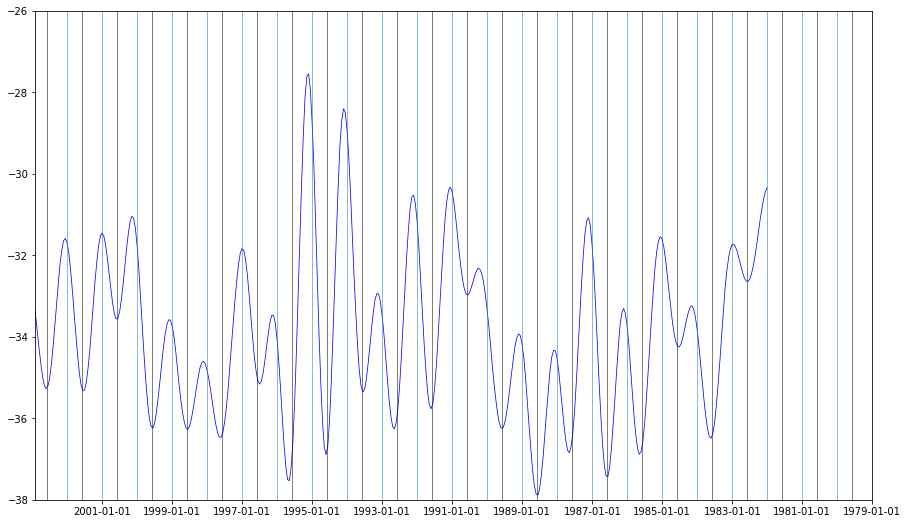

In [11]:
#Create df of detrended WDC d18O record on monthly intevals from 198201-200212 (then match with merra 1980-2000)
#Trough in August and Peak near January

df_WDC_d18O_NEW_198201_200212 = df_WDC_d18O_NEW.loc['1982-01-01':'2002-12-31']
print(df_WDC_d18O_NEW_198201_200212.head(n=15))

plt.figure(figsize=(15,9))
plt.plot(df_WDC_d18O_NEW_198201_200212.d18O_Recon_March, color='blue', linewidth=0.75)

xcoords = [np.datetime64('1979-01-01'), np.datetime64('1980-01-01'), np.datetime64('1981-01-01'), np.datetime64('1982-01-01'), np.datetime64('1983-01-01'), 
           np.datetime64('1984-01-01'), np.datetime64('1985-01-01'), np.datetime64('1986-01-01'), np.datetime64('1987-01-01'), np.datetime64('1988-01-01'),
           np.datetime64('1989-01-01'), np.datetime64('1990-01-01'), np.datetime64('1991-01-01'), np.datetime64('1992-01-01'), np.datetime64('1993-01-01'), 
           np.datetime64('1994-01-01'), np.datetime64('1995-01-01'), np.datetime64('1996-01-01'), np.datetime64('1997-01-01'), np.datetime64('1998-01-01'),
           np.datetime64('1999-01-01'), np.datetime64('2000-01-01'), np.datetime64('2001-01-01'), np.datetime64('2002-01-01'), np.datetime64('2003-01-01')]

for xc in xcoords:
    plt.axvline(x=xc,linewidth=0.5)

xcoords = [np.datetime64('1979-08-01'), np.datetime64('1980-08-01'), np.datetime64('1981-08-01'), np.datetime64('1982-08-01'), np.datetime64('1983-08-01'), 
           np.datetime64('1984-08-01'), np.datetime64('1985-08-01'), np.datetime64('1986-08-01'), np.datetime64('1987-08-01'), np.datetime64('1988-08-01'),
           np.datetime64('1989-08-01'), np.datetime64('1990-08-01'), np.datetime64('1991-08-01'), np.datetime64('1992-08-01'), np.datetime64('1993-08-01'), 
           np.datetime64('1994-08-01'), np.datetime64('1995-08-01'), np.datetime64('1996-08-01'), np.datetime64('1997-08-01'), np.datetime64('1998-08-01'),
           np.datetime64('1999-08-01'), np.datetime64('2000-08-01'), np.datetime64('2001-08-01'), np.datetime64('2002-08-01'), np.datetime64('2003-08-01')]
for xc in xcoords:
    plt.axvline(x=xc,linewidth=0.5,color='k')

plt.xlim(np.datetime64('2002-12-01'), np.datetime64('1979-01-01'))  # decreasing time
plt.xticks(np.arange(np.datetime64('1979'), np.datetime64('2003'), 2))
plt.ylim(-38, -26)  # decreasing time
plt.yticks(np.arange(-38, -24, 2))
plt.show()

#Matches figure from Tyler


# Making Figure for Paper Reviews

In [73]:
# #Create df of detrended WDC d18O record on monthly intevals from 198201-200212 (then match with merra 1980-2000)
# #Trough in August and Peak near January

# df_WDC_d18O_NEW_198201_200212 = df_WDC_d18O_NEW.loc['1982-01-01':'2002-12-31']
# print(df_WDC_d18O_NEW_198201_200212.head(n=15))

# plt.figure(figsize=(15,9))
# plt.plot(df_WDC_d18O_NEW_198201_200212.d18O_Recon_March, color='blue', linewidth=1.25, marker='o', markersize='3')
# plt.plot(df_WDC_d18O_NEW_198201_200212.d18O_Raw_March, color='red', linewidth=1.25, marker='o', markersize='3')
# plt.plot(d_not_detrend['d18O_Recon_March'], color='black', linewidth=1.25, marker='o', markersize='3')

# xcoords = [np.datetime64('1981-01-01'), np.datetime64('1982-01-01'), np.datetime64('1983-01-01'), 
#            np.datetime64('1984-01-01'), np.datetime64('1985-01-01'), np.datetime64('1986-01-01'), np.datetime64('1987-01-01'), np.datetime64('1988-01-01'),
#            np.datetime64('1989-01-01'), np.datetime64('1990-01-01'), np.datetime64('1991-01-01'), np.datetime64('1992-01-01'), np.datetime64('1993-01-01'), 
#            np.datetime64('1994-01-01'), np.datetime64('1995-01-01'), np.datetime64('1996-01-01'), np.datetime64('1997-01-01'), np.datetime64('1998-01-01'),
#            np.datetime64('1999-01-01'), np.datetime64('2000-01-01'), np.datetime64('2001-01-01'), np.datetime64('2002-01-01'), np.datetime64('2003-01-01')]

# for xc in xcoords:
#     plt.axvline(x=xc,linewidth=0.5, color='gray')

# xcoords = [np.datetime64('1981-08-01'), np.datetime64('1982-08-01'), np.datetime64('1983-08-01'), 
#            np.datetime64('1984-08-01'), np.datetime64('1985-08-01'), np.datetime64('1986-08-01'), np.datetime64('1987-08-01'), np.datetime64('1988-08-01'),
#            np.datetime64('1989-08-01'), np.datetime64('1990-08-01'), np.datetime64('1991-08-01'), np.datetime64('1992-08-01'), np.datetime64('1993-08-01'), 
#            np.datetime64('1994-08-01'), np.datetime64('1995-08-01'), np.datetime64('1996-08-01'), np.datetime64('1997-08-01'), np.datetime64('1998-08-01'),
#            np.datetime64('1999-08-01'), np.datetime64('2000-08-01'), np.datetime64('2001-08-01'), np.datetime64('2002-08-01'), np.datetime64('2003-08-01')]
# for xc in xcoords:
#     plt.axvline(x=xc,linewidth=0.5, linestyle='--', color='gray', dashes=(15, 15))

# plt.xlim(np.datetime64('2003-12-01'), np.datetime64('1981-01-01'))  # decreasing time
# plt.xticks(np.arange(np.datetime64('1981'), np.datetime64('2005'), 2), fontsize=11)
# plt.ylim(-38, -26)  # decreasing time
# plt.yticks(np.arange(-38, -24, 2), fontsize=12)
# plt.ylabel('d18O (‰)', fontsize=14)
# plt.title('WAIS Divide Core d18O of Precipitation at Deposition', fontsize=18)
# plt.show()

# #Matches figure from Tyler


            d18O_Raw_March  d18O_Recon_March
time                                        
1982-01-04      -30.994990        -30.343587
1982-01-22      -30.872929        -30.445309
1982-02-09      -30.979063        -30.624032
1982-02-27      -31.068969        -30.865993
1982-03-18      -31.163774        -31.150089
1982-04-05      -31.416159        -31.456125
1982-04-23      -31.609228        -31.764164
1982-05-11      -31.930761        -32.048277
1982-05-30      -32.217032        -32.291075
1982-06-17      -32.363747        -32.478298
1982-07-05      -32.546720        -32.597983
1982-07-23      -32.489790        -32.649478
1982-08-11      -32.546054        -32.630353
1982-08-29      -32.562385        -32.550617
1982-09-16      -32.565523        -32.422053


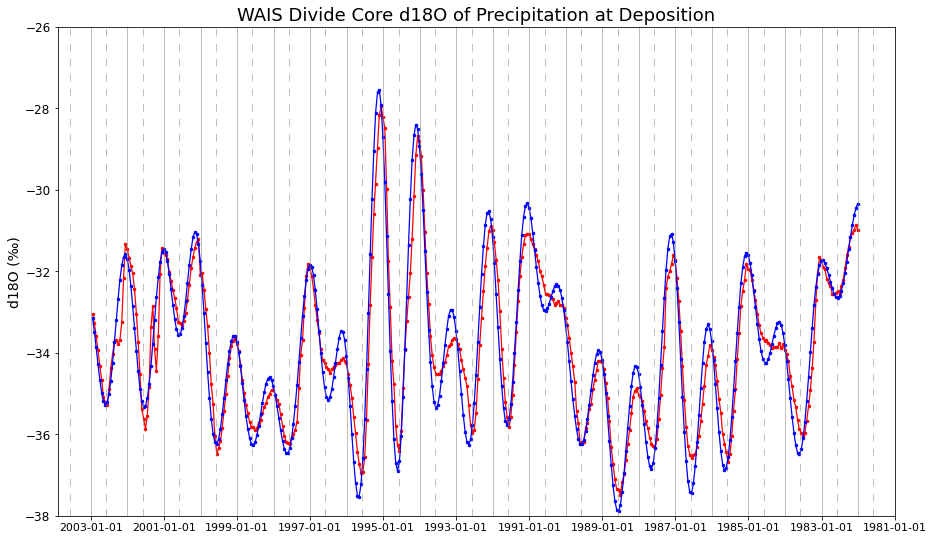

In [75]:
#Create df of detrended WDC d18O record on monthly intevals from 198201-200212 (then match with merra 1980-2000)
#Trough in August and Peak near January

df_WDC_d18O_NEW_198201_200212 = df_WDC_d18O_NEW.loc['1982-01-01':'2002-12-31']
print(df_WDC_d18O_NEW_198201_200212.head(n=15))

plt.figure(figsize=(15,9))
plt.plot(df_WDC_d18O_NEW_198201_200212.d18O_Recon_March, color='blue', linewidth=1.25, marker='o', markersize='2.5', zorder=1)
plt.plot(df_WDC_d18O_NEW_198201_200212.d18O_Raw_March, color='red', linewidth=1.25, marker='o', markersize='2.5', zorder=0)
#plt.plot(d_not_detrend['d18O_Recon_March'], color='black', linewidth=1.25, marker='o', markersize='3')

xcoords = [np.datetime64('1981-01-01'), np.datetime64('1982-01-01'), np.datetime64('1983-01-01'), 
           np.datetime64('1984-01-01'), np.datetime64('1985-01-01'), np.datetime64('1986-01-01'), np.datetime64('1987-01-01'), np.datetime64('1988-01-01'),
           np.datetime64('1989-01-01'), np.datetime64('1990-01-01'), np.datetime64('1991-01-01'), np.datetime64('1992-01-01'), np.datetime64('1993-01-01'), 
           np.datetime64('1994-01-01'), np.datetime64('1995-01-01'), np.datetime64('1996-01-01'), np.datetime64('1997-01-01'), np.datetime64('1998-01-01'),
           np.datetime64('1999-01-01'), np.datetime64('2000-01-01'), np.datetime64('2001-01-01'), np.datetime64('2002-01-01'), np.datetime64('2003-01-01')]

for xc in xcoords:
    plt.axvline(x=xc, linewidth=0.5, color='gray')

xcoords = [np.datetime64('1981-08-01'), np.datetime64('1982-08-01'), np.datetime64('1983-08-01'), 
           np.datetime64('1984-08-01'), np.datetime64('1985-08-01'), np.datetime64('1986-08-01'), np.datetime64('1987-08-01'), np.datetime64('1988-08-01'),
           np.datetime64('1989-08-01'), np.datetime64('1990-08-01'), np.datetime64('1991-08-01'), np.datetime64('1992-08-01'), np.datetime64('1993-08-01'), 
           np.datetime64('1994-08-01'), np.datetime64('1995-08-01'), np.datetime64('1996-08-01'), np.datetime64('1997-08-01'), np.datetime64('1998-08-01'),
           np.datetime64('1999-08-01'), np.datetime64('2000-08-01'), np.datetime64('2001-08-01'), np.datetime64('2002-08-01'), np.datetime64('2003-08-01')]
for xc in xcoords:
    plt.axvline(x=xc, linewidth=0.5, linestyle='--', color='gray', dashes=(15, 15))

plt.xlim(np.datetime64('2003-12-01'), np.datetime64('1981-01-01'))  # decreasing time
plt.xticks(np.arange(np.datetime64('1981'), np.datetime64('2005'), 2), fontsize=11)
plt.ylim(-38, -26)  # decreasing time
plt.yticks(np.arange(-38, -24, 2), fontsize=12)
plt.ylabel('d18O (‰)', fontsize=14)
plt.title('WAIS Divide Core d18O of Precipitation at Deposition', fontsize=18)


plt.savefig(FIG_PATH+'/New_Regression_Figure_WDC_d18O_Timeseries_20210417.pdf',bbox_inches='tight', pad_inches=0.05)


plt.show()

#Matches figure from Tyler


            d18O_Raw_March  d18O_Recon_March
time                                        
1982-01-04      -30.994990        -30.343587
1982-01-22      -30.872929        -30.445309
1982-02-09      -30.979063        -30.624032
1982-02-27      -31.068969        -30.865993
1982-03-18      -31.163774        -31.150089
1982-04-05      -31.416159        -31.456125
1982-04-23      -31.609228        -31.764164
1982-05-11      -31.930761        -32.048277
1982-05-30      -32.217032        -32.291075
1982-06-17      -32.363747        -32.478298
1982-07-05      -32.546720        -32.597983
1982-07-23      -32.489790        -32.649478
1982-08-11      -32.546054        -32.630353
1982-08-29      -32.562385        -32.550617
1982-09-16      -32.565523        -32.422053


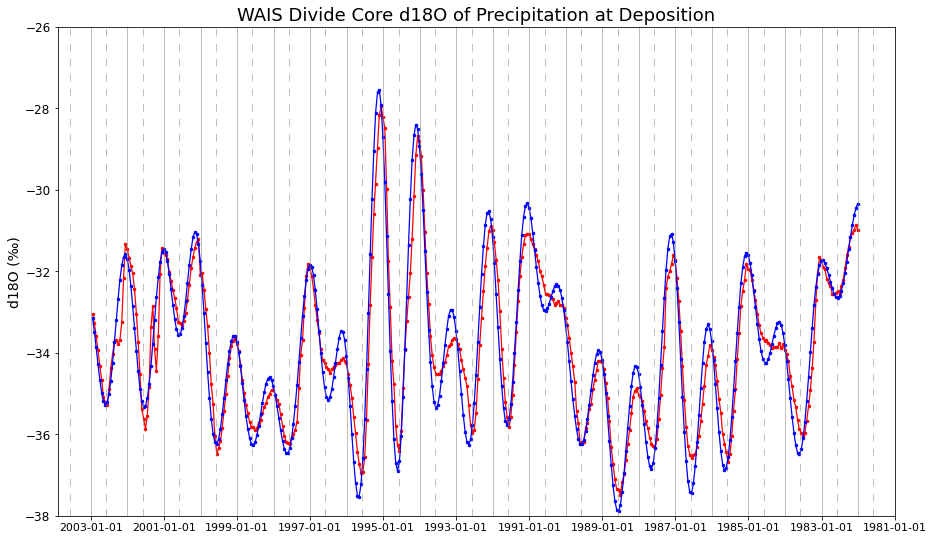

In [75]:
#Create df of detrended WDC d18O record on monthly intevals from 198201-200212 (then match with merra 1980-2000)
#Trough in August and Peak near January

df_WDC_d18O_NEW_198201_200212 = df_WDC_d18O_NEW.loc['1982-01-01':'2002-12-31']
print(df_WDC_d18O_NEW_198201_200212.head(n=15))

plt.figure(figsize=(15,9))
plt.plot(df_WDC_d18O_NEW_198201_200212.d18O_Recon_March, color='blue', linewidth=1.25, marker='o', markersize='2.5', zorder=1)
plt.plot(df_WDC_d18O_NEW_198201_200212.d18O_Raw_March, color='red', linewidth=1.25, marker='o', markersize='2.5', zorder=0)
#plt.plot(d_not_detrend['d18O_Recon_March'], color='black', linewidth=1.25, marker='o', markersize='3')

xcoords = [np.datetime64('1981-01-01'), np.datetime64('1982-01-01'), np.datetime64('1983-01-01'), 
           np.datetime64('1984-01-01'), np.datetime64('1985-01-01'), np.datetime64('1986-01-01'), np.datetime64('1987-01-01'), np.datetime64('1988-01-01'),
           np.datetime64('1989-01-01'), np.datetime64('1990-01-01'), np.datetime64('1991-01-01'), np.datetime64('1992-01-01'), np.datetime64('1993-01-01'), 
           np.datetime64('1994-01-01'), np.datetime64('1995-01-01'), np.datetime64('1996-01-01'), np.datetime64('1997-01-01'), np.datetime64('1998-01-01'),
           np.datetime64('1999-01-01'), np.datetime64('2000-01-01'), np.datetime64('2001-01-01'), np.datetime64('2002-01-01'), np.datetime64('2003-01-01')]

for xc in xcoords:
    plt.axvline(x=xc, linewidth=0.5, color='gray')

xcoords = [np.datetime64('1981-08-01'), np.datetime64('1982-08-01'), np.datetime64('1983-08-01'), 
           np.datetime64('1984-08-01'), np.datetime64('1985-08-01'), np.datetime64('1986-08-01'), np.datetime64('1987-08-01'), np.datetime64('1988-08-01'),
           np.datetime64('1989-08-01'), np.datetime64('1990-08-01'), np.datetime64('1991-08-01'), np.datetime64('1992-08-01'), np.datetime64('1993-08-01'), 
           np.datetime64('1994-08-01'), np.datetime64('1995-08-01'), np.datetime64('1996-08-01'), np.datetime64('1997-08-01'), np.datetime64('1998-08-01'),
           np.datetime64('1999-08-01'), np.datetime64('2000-08-01'), np.datetime64('2001-08-01'), np.datetime64('2002-08-01'), np.datetime64('2003-08-01')]
for xc in xcoords:
    plt.axvline(x=xc, linewidth=0.5, linestyle='--', color='gray', dashes=(15, 15))

plt.xlim(np.datetime64('2003-12-01'), np.datetime64('1981-01-01'))  # decreasing time
plt.xticks(np.arange(np.datetime64('1981'), np.datetime64('2005'), 2), fontsize=11)
plt.ylim(-38, -26)  # decreasing time
plt.yticks(np.arange(-38, -24, 2), fontsize=12)
plt.ylabel('d18O (‰)', fontsize=14)
plt.title('WAIS Divide Core d18O of Precipitation at Deposition', fontsize=18)


plt.savefig(FIG_PATH+'/New_Regression_Figure_WDC_d18O_Timeseries_20210417.pdf',bbox_inches='tight', pad_inches=0.05)


plt.show()

#Matches figure from Tyler


            d18O_Raw_March  d18O_Recon_March
time                                        
1982-01-04      -30.994990        -30.343587
1982-01-22      -30.872929        -30.445309
1982-02-09      -30.979063        -30.624032
1982-02-27      -31.068969        -30.865993
1982-03-18      -31.163774        -31.150089
1982-04-05      -31.416159        -31.456125
1982-04-23      -31.609228        -31.764164
1982-05-11      -31.930761        -32.048277
1982-05-30      -32.217032        -32.291075
1982-06-17      -32.363747        -32.478298
1982-07-05      -32.546720        -32.597983
1982-07-23      -32.489790        -32.649478
1982-08-11      -32.546054        -32.630353
1982-08-29      -32.562385        -32.550617
1982-09-16      -32.565523        -32.422053


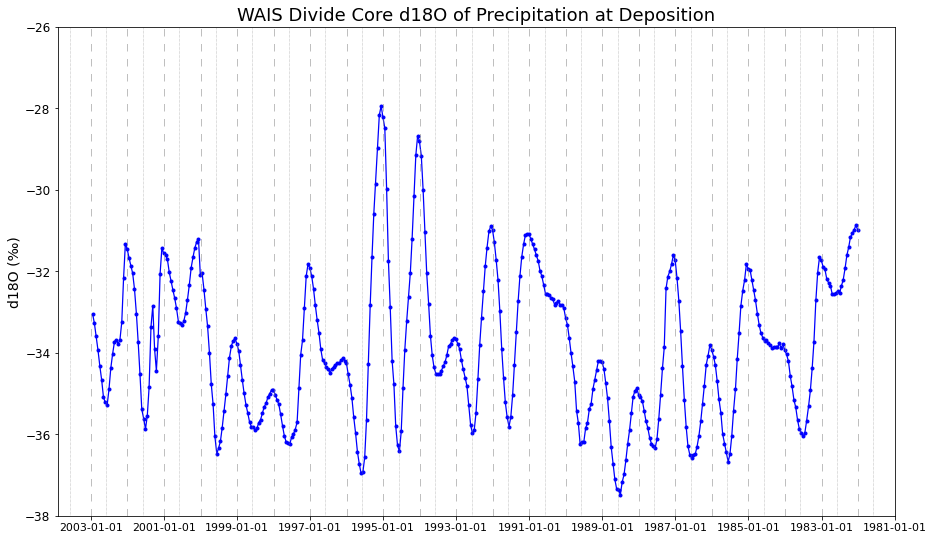

In [55]:
#Create df of detrended WDC d18O record on monthly intevals from 198201-200212 (then match with merra 1980-2000)
#Trough in August and Peak near January

df_WDC_d18O_NEW_198201_200212 = df_WDC_d18O_NEW.loc['1982-01-01':'2002-12-31']
print(df_WDC_d18O_NEW_198201_200212.head(n=15))

plt.figure(figsize=(15,9))
plt.plot(df_WDC_d18O_NEW_198201_200212.d18O_Raw_March, color='blue', linewidth=1.25, marker='o', markersize='3')

xcoords = [np.datetime64('1981-01-01'), np.datetime64('1982-01-01'), np.datetime64('1983-01-01'), 
           np.datetime64('1984-01-01'), np.datetime64('1985-01-01'), np.datetime64('1986-01-01'), np.datetime64('1987-01-01'), np.datetime64('1988-01-01'),
           np.datetime64('1989-01-01'), np.datetime64('1990-01-01'), np.datetime64('1991-01-01'), np.datetime64('1992-01-01'), np.datetime64('1993-01-01'), 
           np.datetime64('1994-01-01'), np.datetime64('1995-01-01'), np.datetime64('1996-01-01'), np.datetime64('1997-01-01'), np.datetime64('1998-01-01'),
           np.datetime64('1999-01-01'), np.datetime64('2000-01-01'), np.datetime64('2001-01-01'), np.datetime64('2002-01-01'), np.datetime64('2003-01-01')]

for xc in xcoords:
    plt.axvline(x=xc,linewidth=0.5, linestyle='--', color='gray', dashes=(15, 15))

xcoords = [np.datetime64('1981-08-01'), np.datetime64('1982-08-01'), np.datetime64('1983-08-01'), 
           np.datetime64('1984-08-01'), np.datetime64('1985-08-01'), np.datetime64('1986-08-01'), np.datetime64('1987-08-01'), np.datetime64('1988-08-01'),
           np.datetime64('1989-08-01'), np.datetime64('1990-08-01'), np.datetime64('1991-08-01'), np.datetime64('1992-08-01'), np.datetime64('1993-08-01'), 
           np.datetime64('1994-08-01'), np.datetime64('1995-08-01'), np.datetime64('1996-08-01'), np.datetime64('1997-08-01'), np.datetime64('1998-08-01'),
           np.datetime64('1999-08-01'), np.datetime64('2000-08-01'), np.datetime64('2001-08-01'), np.datetime64('2002-08-01'), np.datetime64('2003-08-01')]
for xc in xcoords:
    plt.axvline(x=xc,linewidth=0.5, linestyle=':', color='gray')

plt.xlim(np.datetime64('2003-12-01'), np.datetime64('1981-01-01'))  # decreasing time
plt.xticks(np.arange(np.datetime64('1981'), np.datetime64('2005'), 2), fontsize=11)
plt.ylim(-38, -26)  # decreasing time
plt.yticks(np.arange(-38, -24, 2), fontsize=12)
plt.ylabel('d18O (‰)', fontsize=14)
plt.title('WAIS Divide Core d18O of Precipitation at Deposition', fontsize=18)
plt.show()

#Matches figure from Tyler


In [12]:
#Resample such that the 20 pts per year are made into months
#Detrend this monthy WDC Recon Time Series and put back into pd Dataframe
#Detrend first and put into dataframe
#Detrending removes mean!!!

#d18O
d_not_detrend = {'time': df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().index, 'd18O_Recon_March': df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().d18O_Recon_March}
print(d_not_detrend)

d = {'time': df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().index, 'd18O_Recon_March': signal.detrend(df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().d18O_Recon_March)}
df_WDC_d18O_NEW_198201_200212_detrend = pd.DataFrame(data=d)
df_WDC_d18O_NEW_198201_200212_detrend.set_index(df_WDC_d18O_NEW_198201_200212_detrend['time'], inplace=True, drop=True)
print(df_WDC_d18O_NEW_198201_200212_detrend.head(n=16))

{'time': DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', name='time', length=252, freq='MS'), 'd18O_Recon_March': time
1982-01-01   -30.394448
1982-02-01   -30.745013
1982-03-01   -31.150089
1982-04-01   -31.610145
1982-05-01   -32.169676
                ...    
2002-08-01   -35.232765
2002-09-01   -34.984753
2002-10-01   -34.476018
2002-11-01   -33.675057
2002-12-01   -33.159919
Freq: MS, Name: d18O_Recon_March, Length: 252, dtype: float64}
                 time  d18O_Recon_March
time                                   
1982-01-01 1982-01-01          3.547851
1982-02-01 1982-02-01          3.196664
1982-03-01 198

In [64]:
d_not_detrend['d18O_Recon_March'].values

array([-30.39444794, -30.74501263, -31.15008934, -31.6101448 ,
       -32.16967604, -32.47829846, -32.62373023, -32.5904847 ,
       -32.42205313, -32.17213504, -31.86170782, -31.73115986,
       -31.79574705, -32.2222799 , -32.82006862, -33.6903966 ,
       -34.89211734, -35.6923274 , -36.23572599, -36.471734  ,
       -36.27055795, -35.7676443 , -34.87885537, -34.19523869,
       -33.65754636, -33.27846955, -33.27547576, -33.49459812,
       -33.89812513, -34.15738517, -34.24733464, -34.04581581,
       -33.65555427, -33.08385935, -32.28831174, -31.79979145,
       -31.57426902, -31.76542565, -32.30135159, -33.19021137,
       -34.55709301, -35.57087222, -36.35472968, -36.85365475,
       -36.74320396, -36.17834913, -35.06021467, -34.18975774,
       -33.57129305, -33.36023762, -33.72830141, -34.55709447,
       -35.8653476 , -36.77431505, -37.31642843, -37.28260732,
       -36.64567265, -35.51527574, -33.70610456, -32.41452148,
       -31.51305855, -31.11277606, -31.45280048, -32.32

            d18O_Raw_March  d18O_Recon_March
time                                        
1982-01-04      -30.994990        -30.343587
1982-01-22      -30.872929        -30.445309
1982-02-09      -30.979063        -30.624032
1982-02-27      -31.068969        -30.865993
1982-03-18      -31.163774        -31.150089
1982-04-05      -31.416159        -31.456125
1982-04-23      -31.609228        -31.764164
1982-05-11      -31.930761        -32.048277
1982-05-30      -32.217032        -32.291075
1982-06-17      -32.363747        -32.478298
1982-07-05      -32.546720        -32.597983
1982-07-23      -32.489790        -32.649478
1982-08-11      -32.546054        -32.630353
1982-08-29      -32.562385        -32.550617
1982-09-16      -32.565523        -32.422053


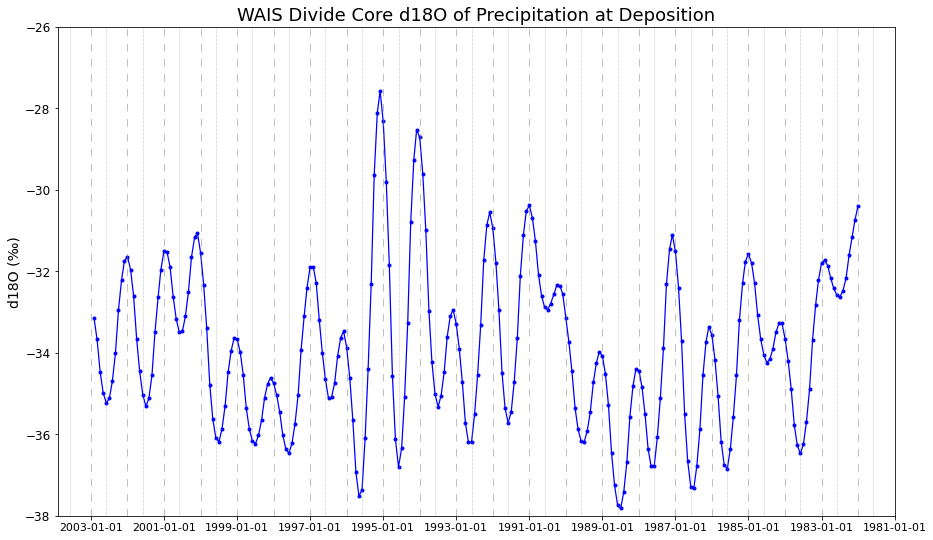

In [65]:
#Create df of detrended WDC d18O record on monthly intevals from 198201-200212 (then match with merra 1980-2000)
#Trough in August and Peak near January

df_WDC_d18O_NEW_198201_200212 = df_WDC_d18O_NEW.loc['1982-01-01':'2002-12-31']
print(df_WDC_d18O_NEW_198201_200212.head(n=15))

plt.figure(figsize=(15,9))
plt.plot(d_not_detrend['d18O_Recon_March'], color='blue', linewidth=1.25, marker='o', markersize='3')

xcoords = [np.datetime64('1981-01-01'), np.datetime64('1982-01-01'), np.datetime64('1983-01-01'), 
           np.datetime64('1984-01-01'), np.datetime64('1985-01-01'), np.datetime64('1986-01-01'), np.datetime64('1987-01-01'), np.datetime64('1988-01-01'),
           np.datetime64('1989-01-01'), np.datetime64('1990-01-01'), np.datetime64('1991-01-01'), np.datetime64('1992-01-01'), np.datetime64('1993-01-01'), 
           np.datetime64('1994-01-01'), np.datetime64('1995-01-01'), np.datetime64('1996-01-01'), np.datetime64('1997-01-01'), np.datetime64('1998-01-01'),
           np.datetime64('1999-01-01'), np.datetime64('2000-01-01'), np.datetime64('2001-01-01'), np.datetime64('2002-01-01'), np.datetime64('2003-01-01')]

for xc in xcoords:
    plt.axvline(x=xc,linewidth=0.5, linestyle='--', color='gray', dashes=(15, 15))

xcoords = [np.datetime64('1981-08-01'), np.datetime64('1982-08-01'), np.datetime64('1983-08-01'), 
           np.datetime64('1984-08-01'), np.datetime64('1985-08-01'), np.datetime64('1986-08-01'), np.datetime64('1987-08-01'), np.datetime64('1988-08-01'),
           np.datetime64('1989-08-01'), np.datetime64('1990-08-01'), np.datetime64('1991-08-01'), np.datetime64('1992-08-01'), np.datetime64('1993-08-01'), 
           np.datetime64('1994-08-01'), np.datetime64('1995-08-01'), np.datetime64('1996-08-01'), np.datetime64('1997-08-01'), np.datetime64('1998-08-01'),
           np.datetime64('1999-08-01'), np.datetime64('2000-08-01'), np.datetime64('2001-08-01'), np.datetime64('2002-08-01'), np.datetime64('2003-08-01')]
for xc in xcoords:
    plt.axvline(x=xc,linewidth=0.5, linestyle=':', color='gray')

plt.xlim(np.datetime64('2003-12-01'), np.datetime64('1981-01-01'))  # decreasing time
plt.xticks(np.arange(np.datetime64('1981'), np.datetime64('2005'), 2), fontsize=11)
plt.ylim(-38, -26)  # decreasing time
plt.yticks(np.arange(-38, -24, 2), fontsize=12)
plt.ylabel('d18O (‰)', fontsize=14)
plt.title('WAIS Divide Core d18O of Precipitation at Deposition', fontsize=18)
plt.show()

#Matches figure from Tyler


       month  d18O_Recon_March
month                         
1          1          1.739821
2          2          1.842327
3          3          1.483292
4          4          0.766365
5          5         -0.361603
6          6         -1.152202
7          7         -1.668557
8          8         -1.806641
9          9         -1.476368
10        10         -0.795825
11        11          0.321896
12        12          1.107495


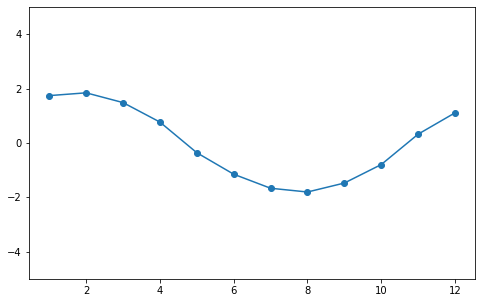

In [13]:
#Create df of detrended WDC_dD_NEW dD record on monthly intevals from 198201-200212 WITH CLIMATOLOGY REMOVED

#Remove climatology second, see below, works best to change into xr data array first
#xarray


#d18O
da_WDC_d18O_NEW_198201_200212_detrend = xr.DataArray(df_WDC_d18O_NEW_198201_200212_detrend.d18O_Recon_March.values, coords={'time': df_WDC_d18O_NEW_198201_200212_detrend.index}, dims=('time'))
# da_WDC_d18O_NEW_198201_200212_detrend

#calculte climatology
da_WDC_d18O_NEW_198201_200212_detrend_climatology = da_WDC_d18O_NEW_198201_200212_detrend.groupby('time.month').mean('time')
# plt.plot(da_WDC_d18O_NEW_198201_200212_detrend_climatology)
# #plt.savefig(FIG_PATH+'/fig01_WDC_d18O_NEW_d18O_climatology.png',bbox_inches='tight', pad_inches=0.01)
# plt.show()

#turn back into pd DataFrame
d = {'month': da_WDC_d18O_NEW_198201_200212_detrend_climatology.coords['month'], 'd18O_Recon_March': da_WDC_d18O_NEW_198201_200212_detrend_climatology.values}
df_WDC_d18O_NEW_198201_200212_detrend_climatology = pd.DataFrame(data=d)
df_WDC_d18O_NEW_198201_200212_detrend_climatology.set_index(df_WDC_d18O_NEW_198201_200212_detrend_climatology['month'], inplace=True, drop=True)
print(df_WDC_d18O_NEW_198201_200212_detrend_climatology)
plt.figure(figsize=(8,5))
plt.plot(df_WDC_d18O_NEW_198201_200212_detrend_climatology.month.values, df_WDC_d18O_NEW_198201_200212_detrend_climatology.d18O_Recon_March.values, marker='o')
plt.ylim([-5,5])
#plt.savefig(FIG_PATH+'/fig01_WDC_d18O_NEW_d18O_climatology.png',bbox_inches='tight', pad_inches=0.01)
plt.show()



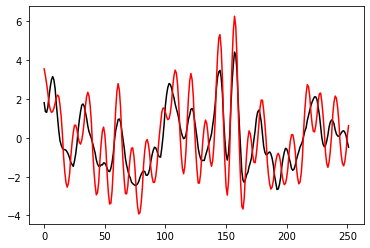

                 time  d18O_Recon_March
time                                   
1982-01-01 1982-01-01          1.808031
1982-02-01 1982-02-01          1.354337
1982-03-01 1982-03-01          1.307673
1982-04-01 1982-04-01          1.563923
1982-05-01 1982-05-01          2.131737


In [14]:
#remove climatology
#d18O
da_WDC_d18O_NEW_198201_200212_detrend_anoms = da_WDC_d18O_NEW_198201_200212_detrend.groupby('time.month') - da_WDC_d18O_NEW_198201_200212_detrend_climatology

plt.plot(da_WDC_d18O_NEW_198201_200212_detrend_anoms,color='k')
plt.plot(da_WDC_d18O_NEW_198201_200212_detrend,color='r')
plt.show()

#turn back into pd DataFrame
d = {'time': da_WDC_d18O_NEW_198201_200212_detrend.coords['time'], 'd18O_Recon_March': da_WDC_d18O_NEW_198201_200212_detrend_anoms.values}
df_WDC_d18O_NEW_198201_200212_detrend_anoms = pd.DataFrame(data=d)
df_WDC_d18O_NEW_198201_200212_detrend_anoms.set_index(df_WDC_d18O_NEW_198201_200212_detrend_anoms['time'], inplace=True, drop=True)
print(df_WDC_d18O_NEW_198201_200212_detrend_anoms.head(n=5))

### Detrending and removing climatology for the T2M variable. (Not using the normalized data here)

In [15]:
#params to be set

#Time period to calc seasonal (monthly) cycle:
time_lo     = '1980-01-01'
time_hi    = '2000-12-31' 

#Define the Tropical Pacific per Jeong et al., (2017)
trop_pac_xhi = 290
trop_pac_xlo = 110
trop_pac_yhi = -20 #Had to reverse hi and lo lat values for ERA
trop_pac_ylo = 20  #Had to reverse hi and lo lat values for ERA

asl_xhi_slice = 298
asl_xlo_slice = 170
asl_yhi_slice = -80 #Had to reverse hi and lo lat values for ERA
asl_ylo_slice = -59.6 #Had to reverse hi and lo lat values for ERA

shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
shem_xlo_slice = 0
shem_yhi_slice = -90 #Had to reverse hi and lo lat values for ERA
shem_ylo_slice = -45 #Had to reverse hi and lo lat values for ERA

shem_yhi = -90 #Had to reverse hi and lo lat values for ERA
shem_ylo = -20  #Had to reverse hi and lo lat values for ERA

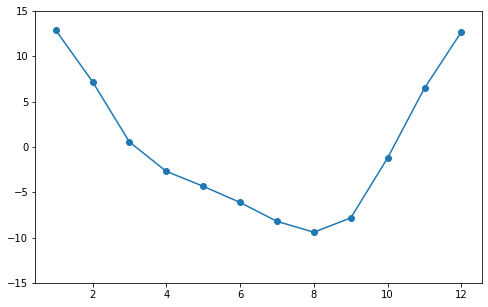

In [16]:
t2m_shem_tmon_merra = t2m_tmon_merra.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem t2m; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended t2m data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(t2m_shem_tmon_merra.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': t2m_shem_tmon_merra.coords['time'], 'lat': t2m_shem_tmon_merra.coords['lat'],'lon': t2m_shem_tmon_merra.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

t2m_shem_tmon_detrend_merra = aa2.where(aa2 != 0.00000, np.nan)

#Create t2m Monthly Climatology at pseudoWDC location from detrended data using data from time_lo to time_hi
t2m_detrend_shem_climatology_merra = t2m_shem_tmon_detrend_merra.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
plt.figure(figsize=(8,5))
plt.plot(t2m_detrend_shem_climatology_merra.month, t2m_detrend_shem_climatology_merra.sel(lat=-78.63, lon=247.5, method='nearest'), marker='o')
plt.ylim([-15,15])
plt.show()

#Find Southern Hemisphere t2m Anoms using the climatology from time_lo to time_hi
t2m_anoms_shem_tmon_detrend_merra = t2m_shem_tmon_detrend_merra.groupby('time.month') - t2m_detrend_shem_climatology_merra


#In case I eventually want to use the normalized dataset, here it is:
#Normalize Southern Hemisphere t2m Anoms (from detrended data)
t2m_anoms_shem_tmon_detrend_norm_merra = (t2m_anoms_shem_tmon_detrend_merra - t2m_anoms_shem_tmon_detrend_merra.mean(dim='time'))/t2m_anoms_shem_tmon_detrend_merra.std(dim='time')
# t2m_anoms_shem_tmon_detrend_norm_merra


In [17]:
t2m_detrend_shem_climatology_merra

<xarray.DataArray (month: 12, lat: 47, lon: 240)>
array([[[ 1.4752134 ,  1.5269692 ,  1.5859854 , ...,  1.4127748 ,
          1.4304224 ,  1.4328886 ],
        [ 1.6302214 ,  1.6337295 ,  1.6733558 , ...,  1.6555973 ,
          1.6538912 ,  1.6450421 ],
        [ 1.8523043 ,  1.8096285 ,  1.7964401 , ...,  1.9206415 ,
          1.8948812 ,  1.8699992 ],
        ...,
        [22.139479  , 22.159885  , 22.1751    , ..., 22.053968  ,
         22.085419  , 22.114273  ],
        [22.19032   , 22.172531  , 22.154324  , ..., 22.239109  ,
         22.2232    , 22.206985  ],
        [21.47292   , 21.47292   , 21.47292   , ..., 21.47292   ,
         21.47292   , 21.47292   ]],

       [[ 2.4787867 ,  2.5319426 ,  2.5743978 , ...,  2.3379886 ,
          2.365604  ,  2.4054122 ],
        [ 2.5275996 ,  2.5828407 ,  2.6165423 , ...,  2.5188756 ,
          2.5009046 ,  2.5029163 ],
        [ 2.623359  ,  2.6390269 ,  2.6674588 , ...,  2.69037   ,
          2.6523287 ,  2.6494236 ],
...
        [11.754759  , 11.7687435 , 11.779231  , ..., 11.697055  ,
         11.7178955 , 11.737541  ],
        [11.945692  , 11.932168  , 11.919255  , ..., 11.986796  ,
         11.973308  , 11.959678  ],
        [11.476935  , 11.476935  , 11.476935  , ..., 11.476935  ,
         11.476935  , 11.476935  ]],

       [[ 0.08004624,  0.12267249,  0.18588093, ...,  0.09067227,
          0.07259523,  0.06167139],
        [ 0.22123346,  0.23939796,  0.28011793, ...,  0.28014264,
          0.25500342,  0.24071485],
        [ 0.39453688,  0.36881766,  0.37589455, ...,  0.45164073,
          0.39864177,  0.39392334],
        ...,
        [21.969284  , 22.01003   , 22.045353  , ..., 21.822638  ,
         21.874374  , 21.923708  ],
        [22.041584  , 22.030552  , 22.018845  , ..., 22.06932   ,
         22.06047   , 22.051268  ],
        [21.2712    , 21.2712    , 21.2712    , ..., 21.2712    ,
         21.2712    , 21.2712    ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -21.0 -22.5 -24.0 -25.5 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [18]:
#Xarray of detrended T2M anomalies from 198001-200012 (monthly)
t2m_anoms_198001_200012_tmon_detrend_merra = t2m_anoms_shem_tmon_detrend_merra
t2m_anoms_198001_200012_tmon_detrend_merra

<xarray.DataArray (time: 252, lat: 47, lon: 240)>
array([[[-0.09779871, -0.12931561, -0.15567422, ..., -0.10944533,
         -0.07914031, -0.08123648],
        [-0.01355267, -0.03906393, -0.05637813, ..., -0.10558856,
         -0.04199088, -0.01681864],
        [ 0.12018597,  0.09238911,  0.03015137, ..., -0.05617964,
          0.00970554,  0.07224059],
        ...,
        [-0.694376  , -0.6479187 , -0.60113716, ..., -0.8314457 ,
         -0.78660583, -0.74067307],
        [-0.25040817, -0.23973465, -0.2282486 , ..., -0.2789154 ,
         -0.26975822, -0.26012802],
        [-0.2544632 , -0.2544632 , -0.2544632 , ..., -0.2544632 ,
         -0.2544632 , -0.2544632 ]],

       [[-0.18339372, -0.16564584, -0.20385718, ..., -0.05127597,
         -0.14017057, -0.18470907],
        [-0.16388345, -0.12840343, -0.09950399, ..., -0.09085321,
         -0.10097361, -0.17540741],
        [-0.05738187, -0.08760858, -0.06606984, ..., -0.23629713,
         -0.09291673, -0.08938026],
...
        [ 4.026743  ,  4.0429325 ,  4.0585337 , ...,  3.9766512 ,
          3.9934502 ,  4.0100937 ],
        [ 4.3666897 ,  4.373168  ,  4.377303  , ...,  4.3390665 ,
          4.347974  ,  4.357278  ],
        [ 3.943532  ,  3.943532  ,  3.943532  , ...,  3.943532  ,
          3.943532  ,  3.943532  ]],

       [[ 0.69113487,  0.62995964,  0.52301955, ...,  0.6406834 ,
          0.6667026 ,  0.68202865],
        [ 0.75943553,  0.74447733,  0.6407462 , ...,  0.58725655,
          0.68647337,  0.7312357 ],
        [ 0.7107049 ,  0.81292784,  0.8173046 , ...,  0.60846174,
          0.6751688 ,  0.70166916],
        ...,
        [-0.17998886, -0.19439125, -0.20853806, ..., -0.13643456,
         -0.15106964, -0.16555977],
        [-0.6001663 , -0.59313583, -0.5822754 , ..., -0.607357  ,
         -0.60477066, -0.6024647 ],
        [-1.043951  , -1.043951  , -1.043951  , ..., -1.043951  ,
         -1.043951  , -1.043951  ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2000-12-01
  * lat      (lat) float64 -21.0 -22.5 -24.0 -25.5 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

### Turn monthly data (WDC d18O record and T2M array) into Seasons and Annual Mean

In [19]:
print(df_WDC_d18O_NEW_198201_200212_detrend_anoms.head(n=5))
print(df_WDC_d18O_NEW_198201_200212_detrend.head(n=5))

                 time  d18O_Recon_March
time                                   
1982-01-01 1982-01-01          1.808031
1982-02-01 1982-02-01          1.354337
1982-03-01 1982-03-01          1.307673
1982-04-01 1982-04-01          1.563923
1982-05-01 1982-05-01          2.131737
                 time  d18O_Recon_March
time                                   
1982-01-01 1982-01-01          3.547851
1982-02-01 1982-02-01          3.196664
1982-03-01 1982-03-01          2.790965
1982-04-01 1982-04-01          2.330288
1982-05-01 1982-05-01          1.770134


            d18O_Recon_March
time                        
1982-01-01          1.868674
1983-01-01         -0.890723
1984-01-01          0.815539
1985-01-01         -0.912345
1986-01-01         -0.794855


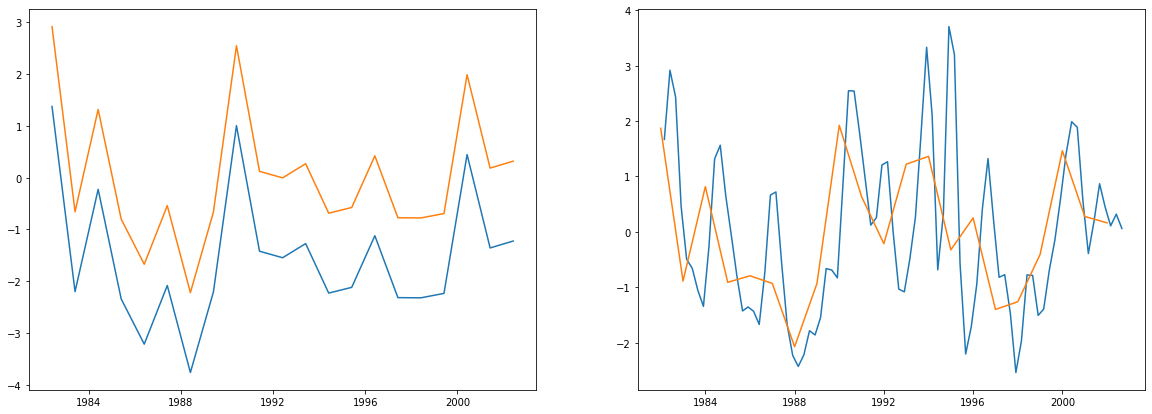

In [20]:
# WDC Seasonal Means:
# Pulling out the Seasonal Time Series and Seasonal ANOM Time Series

# print(df_WDC_d18O_NEW_198201_200212_detrend_anoms.head(n=5))
# print(df_WDC_d18O_NEW_198201_200212_detrend.head(n=5))

#seasonal means from monthly data
df_WDC_seas_1982_2002_detrend = df_WDC_d18O_NEW_198201_200212_detrend[2:(len(df_WDC_d18O_NEW_198201_200212_detrend.index)-1)].resample('3MS', closed='left'  ).mean()
df_WDC_seas_1982_2002_detrend['Seas_Index'] = df_WDC_seas_1982_2002_detrend.index.astype(str).str[5:7]

df_WDC_djf_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '12').dropna()
df_WDC_mam_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '03').dropna()
df_WDC_jja_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '06').dropna()
df_WDC_son_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '09').dropna()

#seasonal means of anoms
df_WDC_seas_1982_2002_detrend_anoms = df_WDC_d18O_NEW_198201_200212_detrend_anoms[2:(len(df_WDC_d18O_NEW_198201_200212_detrend_anoms.index)-1)].resample('3MS', closed='left'  ).mean()
df_WDC_seas_1982_2002_detrend_anoms['Seas_Index'] = df_WDC_seas_1982_2002_detrend_anoms.index.astype(str).str[5:7]
# print(df_WDC_seas_1982_2002_detrend_anoms)

df_WDC_djf_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '12').dropna()
df_WDC_mam_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '03').dropna()
df_WDC_jja_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '06').dropna()
df_WDC_son_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '09').dropna()


# WDC JJA Mean:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(df_WDC_jja_1982_2002_detrend.d18O_Recon_March)
plt.plot(df_WDC_jja_1982_2002_detrend_anoms.d18O_Recon_March)
# plt.show()
# Removing the climatology does not change pattern, only centers variability about zero
# Will use the data with climatology removed


# WDC Annual Mean:
df_WDC_ann_mean_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.resample('AS', closed='left').mean()
plt.subplot(1,2,2)
plt.plot(df_WDC_seas_1982_2002_detrend_anoms.d18O_Recon_March)
plt.plot(df_WDC_ann_mean_1982_2002_detrend_anoms.d18O_Recon_March)
print(df_WDC_ann_mean_1982_2002_detrend_anoms.head(n=5))
# Annual cycle looks good

In [21]:
# T2M field in Seasonal Means:
# NOTE, T2M SEASONAL MEANS ARE CENTERED ON CENTER MONTH; in WDC SEASONAL MEANS ARE NUMBERED BY THE FIRST MONTH

rolls_for_seas = t2m_anoms_198001_200012_tmon_detrend_merra.rolling(time=3, min_periods=3, center=True).mean()
djf_t2m_anoms_1980_2000_detrend_merra = rolls_for_seas[12::12,:]
mam_t2m_anoms_1980_2000_detrend_merra = rolls_for_seas[3::12,:]
jja_t2m_anoms_1980_2000_detrend_merra = rolls_for_seas[6::12,:]
son_t2m_anoms_1980_2000_detrend_merra = rolls_for_seas[9::12,:]


#T2M field in Annual Mean:
#Note, time is now list of years 1980, 1980, etc  (not in yyyy-mm-dd)
ann_mean_t2m_anoms_1980_2000_detrend_merra = t2m_anoms_198001_200012_tmon_detrend_merra.groupby('time.year').mean('time')
ann_mean_t2m_anoms_1980_2000_detrend_merra.coords['year']

<xarray.DataArray 'year' (year: 21)>
array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000])
Coordinates:
  * year     (year) int64 1980 1981 1982 1983 1984 ... 1996 1997 1998 1999 2000